# Imports Libraries

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import os 
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import efficientnet.tfkeras as efn
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Flatten, Dense,Conv2D,MaxPool2D,Dropout,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import AUC, CategoricalAccuracy, Precision, Recall
from tensorflow_addons.metrics import F1Score
import tensorflow as tf
import cv2

### My Configuration

In [10]:
# data path
TRAIN_PATH = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Train'
VALIDATION_PATH = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Validation'
TEST_PATH = '/kaggle/input/face-mask-12k-images-dataset/Face Mask Dataset/Test'

# confing model
TARGET_SIZE =   (224,224)
BATCH_SIZE = 256
INIT_LR = 1e-4 
EPOCHS = 20

# Data Preparation

In [11]:
def wrangle_data(path_data):
    filenames = glob(path_data+'/*/*')
    lable_name = []
    file_path = []
    for filename in filenames:
        category = filename.split('/')[-2]
        file_path.append(filename)
        lable_name.append(category)


    df = pd.DataFrame({
        'file_path': file_path,
        'label_name': lable_name
    })
    return df

In [12]:
train_df = wrangle_data(TRAIN_PATH)
val_df = wrangle_data(VALIDATION_PATH)
test_df = wrangle_data(TRAIN_PATH)
train_df.head()

file_path   label_name
0  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithoutMask
1  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithoutMask
2  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithoutMask
3  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithoutMask
4  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithoutMask

In [13]:
print('number of image train = ',train_df.shape)
print('number of image validation = ',val_df.shape)
print('number of image test = ',test_df.shape)

number of image train =  (10000, 2)
number of image validation =  (800, 2)
number of image test =  (10000, 2)


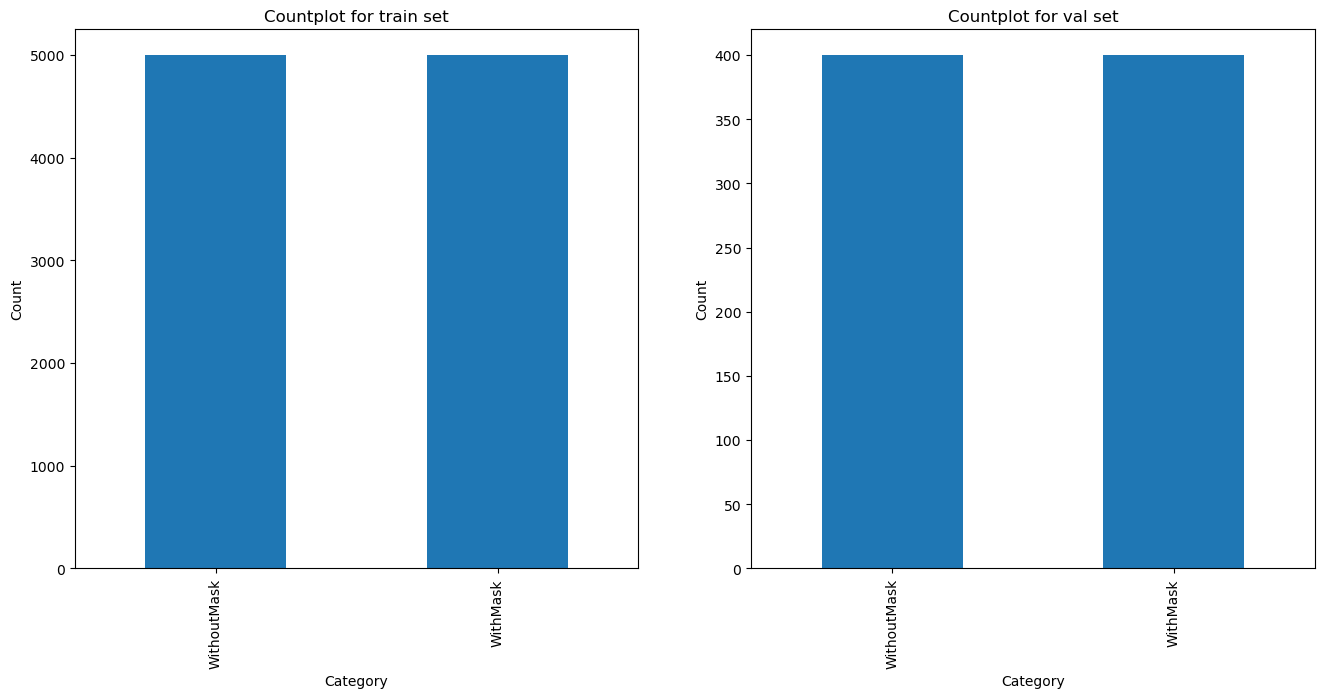

In [14]:
fig, ax = plt.subplots(figsize=(16,7), nrows=1,ncols=2)
train_df['label_name'].value_counts().plot(ax=ax[0],kind='bar', xlabel='Category', ylabel='Count', title='Countplot for train set')
val_df['label_name'].value_counts().plot(ax=ax[1],kind='bar', xlabel='Category', ylabel='Count', title='Countplot for val set')
plt.show()

## Data Augmentation

In [15]:
train_gen = ImageDataGenerator(
    rotation_range=20,
    rescale=1/255.0,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest",
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

# Only rescaling the val set
val_gen = ImageDataGenerator(
    rescale=1/255.0,
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input
)

In [16]:
train_set = train_gen.flow_from_dataframe(
    train_df, 
    x_col='file_path',
    y_col='label_name',
    target_size=TARGET_SIZE, 
    class_mode='categorical', 
    shuffle=True, 
    batch_size=BATCH_SIZE)
val_set = val_gen.flow_from_dataframe(
    val_df, 
    x_col='file_path',
    y_col='label_name',
    target_size=TARGET_SIZE, 
    class_mode='categorical', 
    shuffle=True, 
    batch_size=BATCH_SIZE)

Found 10000 validated image filenames belonging to 2 classes.
Found 800 validated image filenames belonging to 2 classes.


In [17]:
class_dict = {v:k for k,v in train_set.class_indices.items()}
class_dict , train_set.class_indices.items()

({0: 'WithMask', 1: 'WithoutMask'},
 dict_items([('WithMask', 0), ('WithoutMask', 1)]))

In [18]:
train_set.image_shape,val_set.image_shape

((224, 224, 3), (224, 224, 3))

# Visualize Data

In [19]:
def see_examples(datagen, figsize=(16,16),nrows=4, ncols=4):
    fig, ax = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols)
    batch_idx = np.random.randint(low=0, high=len(datagen), size=(nrows,ncols))
    for i in range(nrows):
        for j in range(ncols):
            imgs, labels = datagen[batch_idx[i,j]]
            sample_idx = np.random.randint(low=0, high=len(imgs))
            img = imgs[sample_idx]
            label = labels[sample_idx]
            label = class_dict[np.argmax(label)]
            ax[i,j].axis('off')
            ax[i,j].imshow(img)
            ax[i,j].set_title(label)
    plt.show()

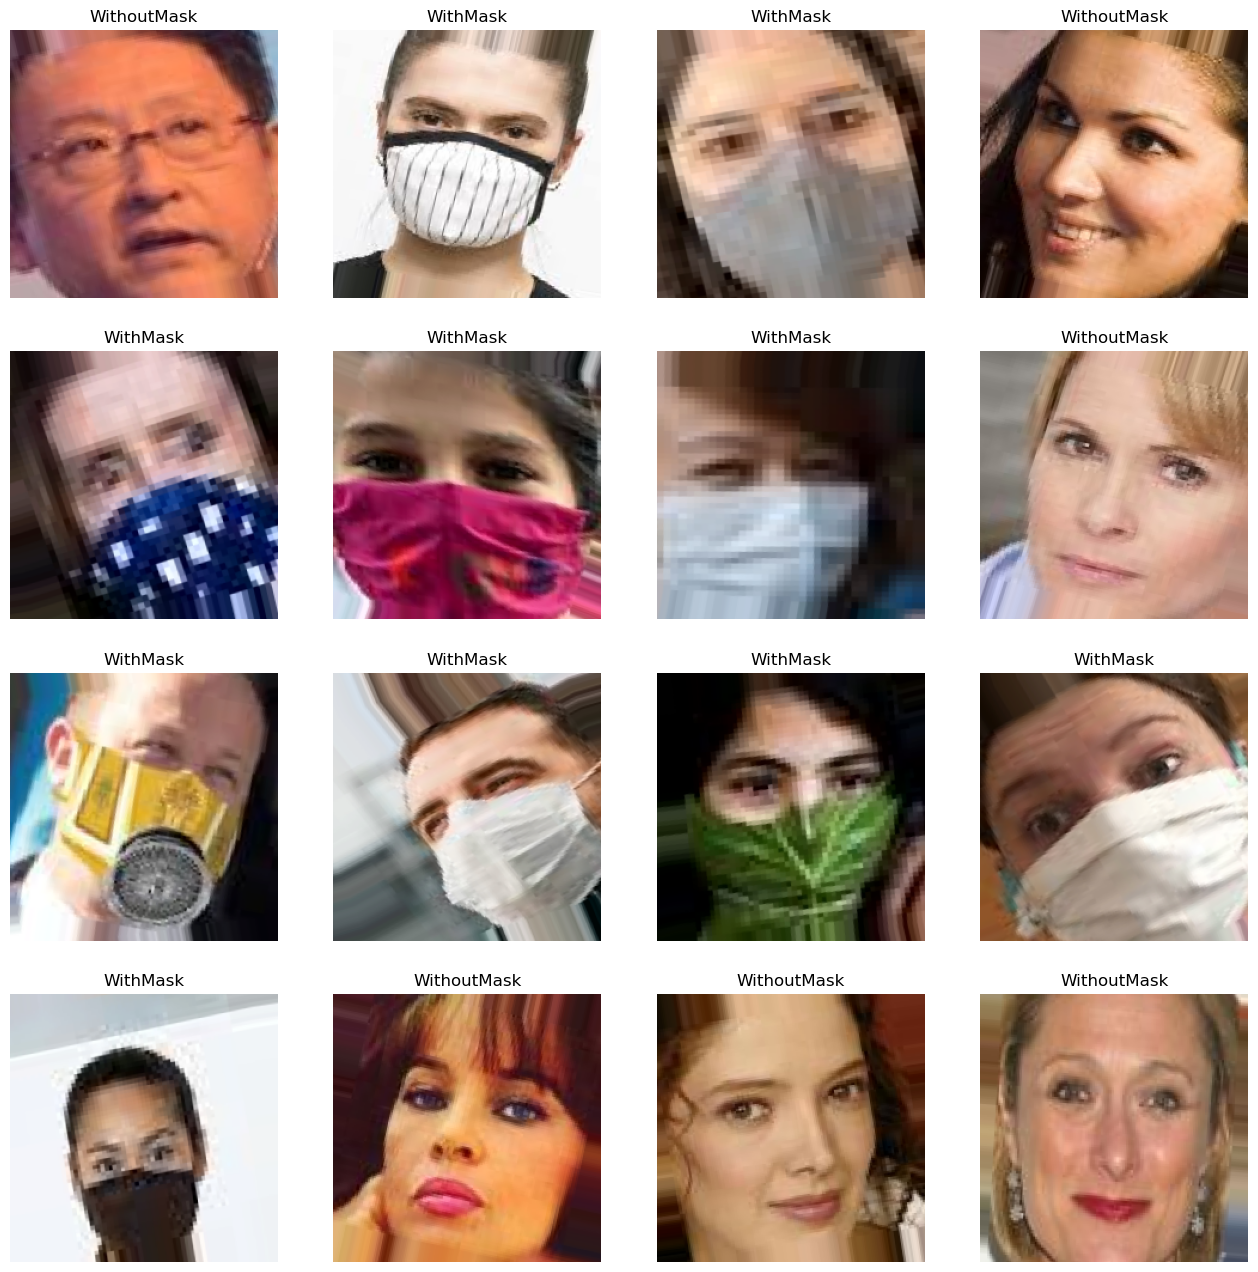

In [20]:
see_examples(train_set)

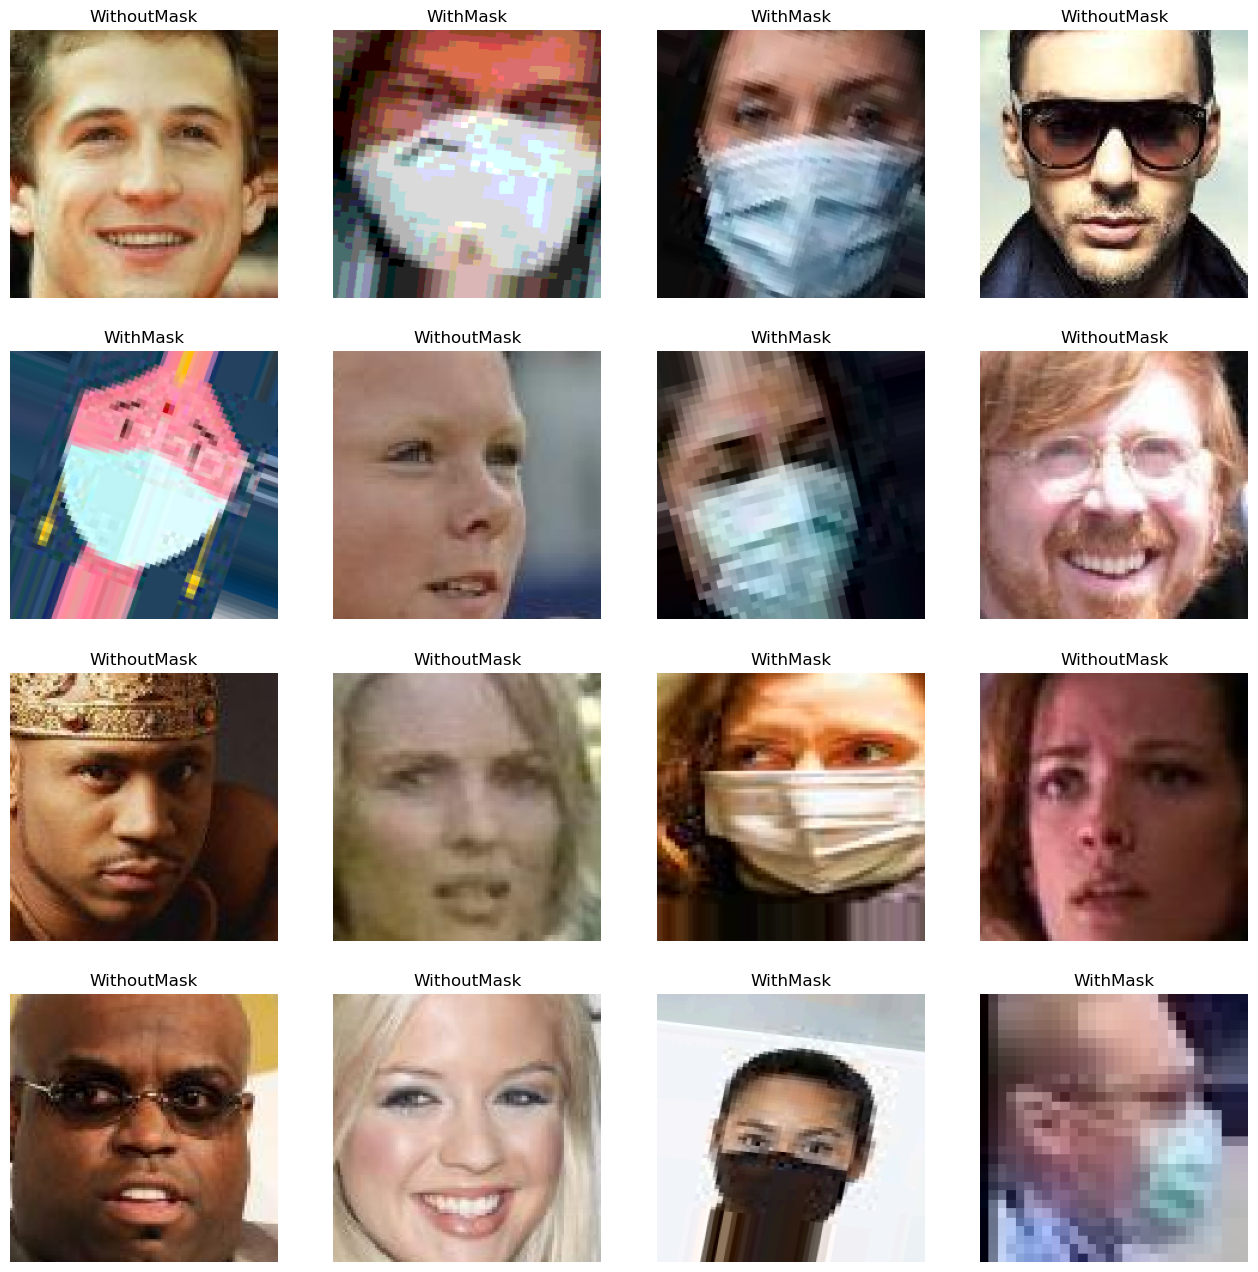

In [21]:
see_examples(val_set)

# Model Building

In [22]:
conv_base = efn.EfficientNetB0(weights='imagenet',
                  include_top=False,
                  input_shape=(TARGET_SIZE[0],TARGET_SIZE[1], 3))


16804768/16804768 [==============================] - 0s 0us/step


In [23]:
conv_base.trainable=True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block6a_expand_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [24]:
model = Sequential([
    conv_base,
    Flatten(),
    
    Dense(units=512, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    Dropout(0.2),
    Dense(units=128, activation='relu'),
    Dropout(0.2),
    Dense(units=64, activation=tf.keras.layers.LeakyReLU(alpha=0.2)),
    Dropout(0.2),
    Dense(units=32, activation='relu'),
    Dense(units=2, activation='softmax')
])

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 512)               32113152  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [26]:
callbacks = [
    EarlyStopping(min_delta=1e-5, patience=5),
    ModelCheckpoint('Mask_detector_model.h5', save_best_only=True)
]
metrics = [
    CategoricalAccuracy(), 
    F1Score(num_classes=2), 
    Precision(), 
    Recall(), 
    AUC()
]
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=INIT_LR),
              loss='categorical_crossentropy',
              metrics=metrics)

## Train Model

In [27]:
history = model.fit(train_set,epochs=EPOCHS, steps_per_epoch=train_set.n//train_set.batch_size,
                   validation_data=val_set, validation_steps=val_set.n//val_set.batch_size,
                   callbacks=callbacks)


Epoch 1/20


2023-04-17 21:02:03.842285: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnet-b0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


39/39 [==============================] - 207s 5s/step - loss: 0.1226 - categorical_accuracy: 0.9531 - f1_score: 0.9531 - precision: 0.9531 - recall: 0.9531 - auc: 0.9905 - val_loss: 0.0496 - val_categorical_accuracy: 0.9844 - val_f1_score: 0.9844 - val_precision: 0.9844 - val_recall: 0.9844 - val_auc: 0.9963
Epoch 2/20
39/39 [==============================] - 143s 4s/step - loss: 0.0137 - categorical_accuracy: 0.9956 - f1_score: 0.9956 - precision: 0.9956 - recall: 0.9956 - auc: 0.9998 - val_loss: 0.0299 - val_categorical_accuracy: 0.9922 - val_f1_score: 0.9922 - val_precision: 0.9922 - val_recall: 0.9922 - val_auc: 0.9983
Epoch 3/20
39/39 [==============================] - 143s 4s/step - loss: 0.0101 - categorical_accuracy: 0.9971 - f1_score: 0.9971 - precision: 0.9971 - recall: 0.9971 - auc: 0.9997 - val_loss: 0.0187 - val_categorical_accuracy: 0.9935 - val_f1_score: 0.9935 - val_precision: 0.9935 - val_recall: 0.9935 - val_auc: 0.9998
Epoch 4/20
39/39 [==============================

In [28]:
history_df = pd.DataFrame(history.history)
history_df.head()

loss  categorical_accuracy                  f1_score  precision  \
0  0.122583              0.953099   [0.9534196, 0.95277464]   0.953099   
1  0.013749              0.995587   [0.99559563, 0.9955784]   0.995587   
2  0.010120              0.997126   [0.9971376, 0.99711514]   0.997126   
3  0.005361              0.998563  [0.99856377, 0.99856263]   0.998563   
4  0.006388              0.997742    [0.9977432, 0.9977412]   0.997742   

     recall       auc  val_loss  val_categorical_accuracy  \
0  0.953099  0.990490  0.049565                  0.984375   
1  0.995587  0.999796  0.029854                  0.992188   
2  0.997126  0.999728  0.018671                  0.993490   
3  0.998563  0.999882  0.018463                  0.996094   
4  0.997742  0.999874  0.007111                  0.998698   

               val_f1_score  val_precision  val_recall   val_auc  
0    [0.9844156, 0.9843342]       0.984375    0.984375  0.996301  
1    [0.9921053, 0.9922681]       0.992188    0.992188  0.998255  
2    [0.9934469, 0.9935317]       0.993490    0.993490  0.999773  
3  [0.99607843, 0.99610895]       0.996094    0.996094  0.998562  
4   [0.9986996, 0.99869627]       0.998698    0.998698  0.999963

In [29]:
history_df['f1_score'] = history_df['f1_score'].apply(np.mean)
history_df['val_f1_score'] = history_df['val_f1_score'].apply(np.mean)

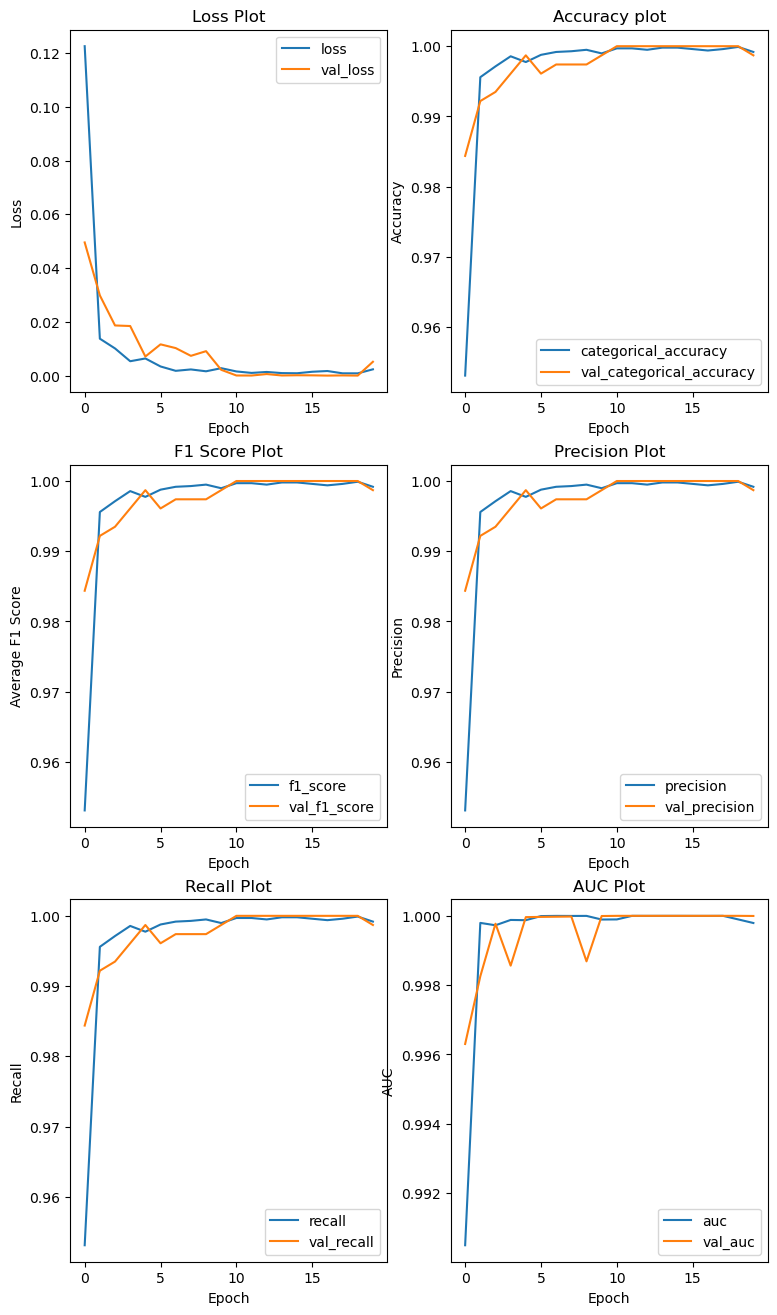

In [30]:
fig, ax = plt.subplots(figsize=(9,16), nrows=3,ncols=2)
history_df[['loss','val_loss']].plot(ax=ax[0,0], xlabel='Epoch',ylabel='Loss', title='Loss Plot')
history_df[['categorical_accuracy','val_categorical_accuracy']].plot(
    ax=ax[0,1], xlabel='Epoch',ylabel='Accuracy',title='Accuracy plot')
history_df[['f1_score','val_f1_score']].plot(ax=ax[1,0],xlabel='Epoch',ylabel='Average F1 Score',title='F1 Score Plot')
history_df[['precision','val_precision']].plot(ax=ax[1,1],xlabel='Epoch',ylabel='Precision',title='Precision Plot')
history_df[['recall','val_recall']].plot(ax=ax[2,0],xlabel='Epoch',ylabel='Recall',title='Recall Plot')
history_df[['auc','val_auc']].plot(ax=ax[2,1],xlabel='Epoch',ylabel='AUC',title='AUC Plot')
plt.show()

# Visualize Test Data

In [31]:
test_set = val_gen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label_name',
    class_mode='categorical',
    target_size=TARGET_SIZE, 
    batch_size=BATCH_SIZE, 
    shuffle=False)

Found 10000 validated image filenames belonging to 2 classes.


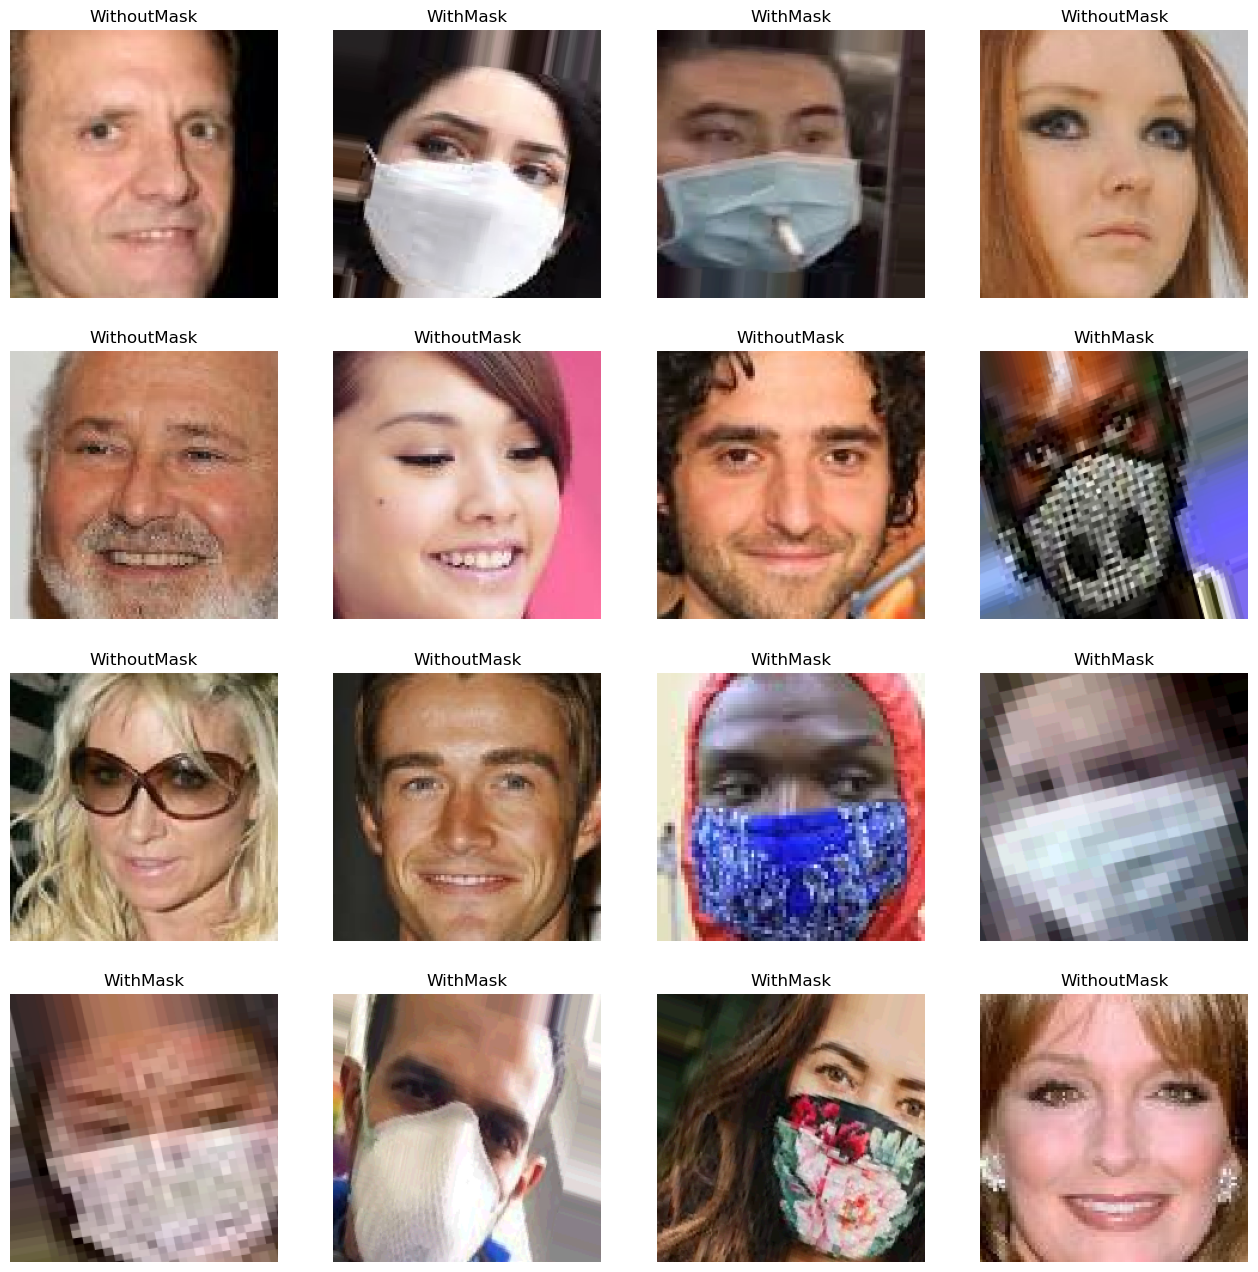

In [32]:
see_examples(test_set)

# Evaluating The Model

In [33]:
best_model = load_model('Mask_detector_model.h5')

In [34]:
test_loss,test_acc, test_f1, test_precision, test_recall, test_auc = best_model.evaluate(test_set)
test_preds = best_model.predict(test_set)
test_preds =test_preds.argmax(axis=1)
test_df.head()

40/40 [==============================] - 40s 973ms/step


file_path   label_name
0  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithoutMask
1  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithoutMask
2  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithoutMask
3  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithoutMask
4  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithoutMask

In [35]:
test_df['Label'] = test_df['label_name'].map(test_set.class_indices)
test_df['Predicted'] = test_preds
test_df.head()

file_path   label_name  Label  \
0  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithoutMask      1   
1  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithoutMask      1   
2  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithoutMask      1   
3  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithoutMask      1   
4  /kaggle/input/face-mask-12k-images-dataset/Fac...  WithoutMask      1   

   Predicted  
0          1  
1          1  
2          1  
3          1  
4          1

In [36]:
conf_mat = confusion_matrix(y_true=test_df['Label'], y_pred=test_df['Predicted'])
conf_mat = pd.DataFrame(conf_mat, index=test_set.class_indices.keys(), columns=test_set.class_indices.keys())
conf_mat

WithMask  WithoutMask
WithMask         5000            0
WithoutMask         0         5000

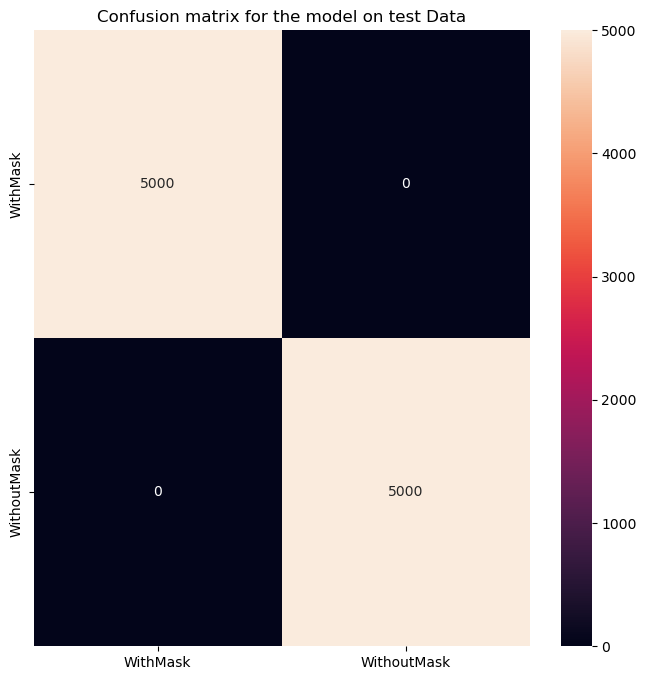

In [37]:
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, ax=ax , fmt='d')
ax.set_title('Confusion matrix for the model on test Data')
plt.show()

In [38]:
print(classification_report(y_true=test_df['Label'], y_pred=test_df['Predicted']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5000
           1       1.00      1.00      1.00      5000

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



# End
## [GitHup](https://github.com/ahmedAEAID) | [LinkedIn](https://www.linkedin.com/in/ahmed-mohamed-abd-elkader-ml/) | [Kaggle](https://www.kaggle.com/ahmedmoabdelkader/)